### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [98]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
import random

from sklearn import datasets
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix,
                            classification_report
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [23]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [24]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

## Change these to select data

In [25]:
table_names = ['civil_liberties', \
               'political_rights', \
               #'freedom_status', \
               #'corruption_perception', \
               'female_legislators', \
               'population_growth', \
               'population_female', \
               #'under_5_mortality', \
               'life_expectancy', \
               #'population_0_14', \
               'population_15_64',  \
               #'population_65_up', \
               #'terror_new', \
               #'peace_new', \
               #'refugees_percapita', \
               #'zscores'
                'zscores']

In [26]:
y_col = table_names[-1]

In [27]:
x_cols = table_names[:-1]

In [28]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [29]:
full_data = pd.DataFrame()

In [30]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['year', 'countrycode'])
    full_data = pd.concat([full_data, year_data])
    


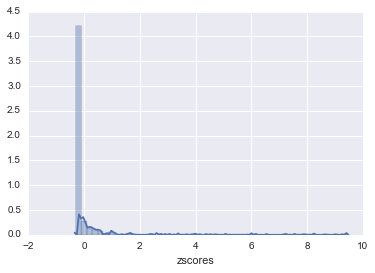

In [31]:
sns.distplot(full_data.dropna()[y_col].astype(float))

(array([ 989.,   22.,    7.,    7.,    7.,    2.,    3.,    3.,    5.,    4.]),
 array([-0.29313644,  0.67991785,  1.65297214,  2.62602643,  3.59908072,
         4.57213501,  5.5451893 ,  6.51824359,  7.49129788,  8.46435217,
         9.43740646]),
 <a list of 10 Patch objects>)

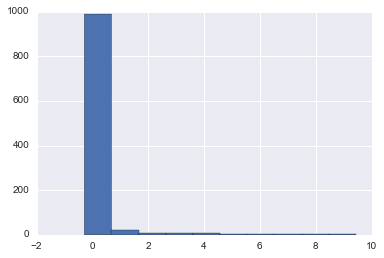

In [32]:
import pylab as pl

pl.hist(sorted(list(full_data.dropna()[y_col].astype(float))))



In [33]:
full_data.head()

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 AFG                        6                 5                27.7   
     AGO                        5                 6                37.3   
     ALB                        3                 3                 7.1   
     ARE                        5                 6                22.5   
     ARG                        2                 2                40.0   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 AFG                   2.485315          48.512909        58.225024   
     AGO                   3.374180          50.493712        49.847390   
     ALB                  -0.767343          49.610212        76.632317   
     ARE                  13.810060          25.880062        76.307756   
     ARG                   1.025393          51.087196        75.166268   

                  population_15_64       zscores  
year countrycode                                  
2008 AFG                 49.946087   6.546331355  
     AGO                 49.356104   0.281696206  
     ALB                 66.816430   0.055357722  
     ARE                 84.600650  -0.267222176  
     ARG                 63.456290   -0.26793528

In [34]:
full_data[y_col] = full_data[y_col].astype(float)

#full_data.loc[full_data[y_col] > 0, y_col] = 1
#full_data.loc[full_data[y_col] <= 0, y_col] = 0

cutoff = full_data[y_col].quantile(.90)
full_data.loc[full_data[y_col] <= cutoff, y_col] = 0
full_data.loc[full_data[y_col] > cutoff, y_col] = 1

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [35]:
def pickleme(temp, filename):
   with open(filename, 'wb') as picklefile:
       pickle.dump(temp, picklefile)


In [36]:
pickleme(full_data, '../final_analysis/ken_m_data.pkl')

In [37]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 FJI                        4                 6                 NaN   
     GIN                        5                 7                 NaN   
     LUX                        1                 1                23.3   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     TKM                        7                 7                 NaN   
     VUT                        2                 2                 3.8   
2009 FJI                        4                 6                 NaN   
     GIN                        6                 7                 NaN   
     LUX                        1                 1                20.0   
     MDG                        4                 6                 NaN   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     VUT                        2                 2                 3.8   
     WSM                        2                 2                 8.2   
2010 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     LUX                        1                 1                20.0   
     NER                        4                 5                 NaN   
     SSD                      NaN               NaN                 NaN   
     TZA                        3                 3                 NaN   
2011 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     HRV                        2                 1                23.8   
     LBY                        6                 7                 NaN   
     LUX                        1                 1                25.0   
     ZAR                        6                 6                 NaN   
2012 FJI                        4                 6                 NaN   
     GHA                        2                 1                 NaN   
     GIN                        5                 5                 NaN   
     LKA                        4                 5                 5.8   
     LUX                        1                 1                21.7   
2013 ARG                        2                 2                 NaN   
     CAF                        7                 7                 NaN   
     EGY                        5                 6                 NaN   
     FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 FJI                   1.010417          48.947707        69.022024   
     GIN                   2.671069          49.966108        54.777585   
     LUX                   1.787497          50.493425        80.539024   
     MMR                   0.651129          51.176312        64.367610   
     SSD                   4.362664          50.051550        52.593317   
     TKM                   1.213341          50.724437        64.756073   
     VUT                   2.416066          49.142388        70.254756   
2009 FJI                   1.020386          48.947824        69.202854   
     GIN                   2.728375          49.955495        55.556146   
     LUX                   1.851775          50.416014        80.636585   
     MDG                   2.814994          50.195519        62.918171   
     MMR                   0.663518          51.184720        64.643561   
     SSD                   4.403674       

In [38]:
full_data = full_data.dropna()

In [39]:
#Get Z scores of rows
#for col in x_cols:
#    full_data[col] = full_data[col].astype(float)
#    full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


#### Get the score values WITHOUT cross validating 

In [40]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True,
                   get_prediction=False
                  ):
    y_test_index=y_test.index
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    roc_auc_value = roc_auc_score(y_test,y_pred)
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: ()'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value, \
                                                                       roc_auc_value))
    elif get_prediction:
        y_pred=pd.Series(y_pred, index=y_test_index)
        return y_pred
        
    else:
        return accuracy_score_value, \
               precision_score_value, \
               recall_score_value, \
               f1_score_value, \
               roc_auc_value, \
               feature_importances

In [41]:
X = full_data[x_cols]
y = full_data[y_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [42]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9206349206349206
Precision: 0.5925925925925926
Recall: 0.5333333333333333
f1: 0.5614035087719299
ROC AUC: ()


In [43]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.9047619047619048
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: ()


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7587301587301587
Precision: 0.18055555555555555
Recall: 0.43333333333333335
f1: 0.2549019607843137
ROC AUC: ()


In [45]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9492063492063492
Precision: 0.85
Recall: 0.5666666666666667
f1: 0.68
ROC AUC: ()


In [46]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9365079365079365
Precision: 0.7777777777777778
Recall: 0.4666666666666667
f1: 0.5833333333333334
ROC AUC: ()


#### Print the ROC curve for a model

In [47]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=2)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.8547368421052632


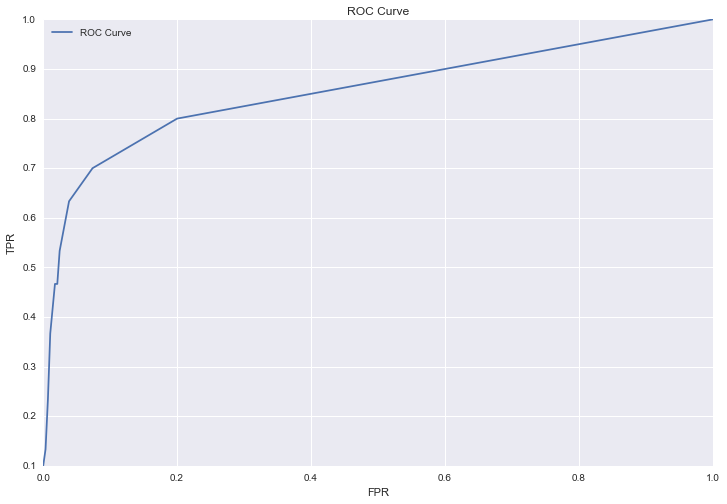

In [48]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

#### Cross Validate and Return Scores 

In [49]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=1)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [50]:
getScoreValuesByCV(X,y)

Accuracy: 0.9685164440614678
Precision: 0.8513871635610766
Recall: 0.8342857142857143
f1: 0.8409563078252813
ROC AUC: 0.9086856028961291


In [51]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9656909831666629
Precision: 0.9312820512820513
Recall: 0.6780952380952382
f1: 0.7486523675378164
ROC AUC: 0.9558936362069194


In [52]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7883553562924976
Precision: 0.25860127699654345
Recall: 0.6114285714285714
f1: 0.3629679169275306
ROC AUC: 0.7336091551630399


In [53]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.946615893460493
Precision: 0.7559360357415277
Recall: 0.7566666666666666
f1: 0.7488744588744589
ROC AUC: 0.8577736006683375


In [54]:
getScoreValuesByCV(X,y, model=LogisticRegression())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.9132687168157361
Precision: 0.75
Recall: 0.1276190476190476
f1: 0.2147826086956522
ROC AUC: 0.7781949582952089


## Modeling with Over Sampling of Training Set

In [55]:
def oversample_data(X_t, y_t, ratio):
    x_columns = X_t.columns
    
    X_t = X_t.reset_index(drop=True).as_matrix()
    y_t = y_t.reset_index(drop=True).as_matrix()

    smote = OverSampler(ratio=ratio, verbose=False)
    smox, smoy = smote.fit_transform(X_t, y_t)
    X_t = pd.DataFrame(smox, columns=x_columns)
    y_t = pd.Series(smoy)
    return X_t, y_t


In [56]:
X = full_data[x_cols]
y = full_data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [57]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])

X_train, y_train = oversample_data(X_train, y_train, ratio)

In [58]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.9142857142857143
Precision: 0.5319148936170213
Recall: 0.8333333333333334
f1: 0.6493506493506493
ROC AUC: ()


In [59]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9396825396825397
Precision: 0.72
Recall: 0.6
f1: 0.6545454545454547
ROC AUC: ()


In [60]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.8158730158730159
Precision: 0.13157894736842105
Recall: 0.16666666666666666
f1: 0.14705882352941177
ROC AUC: ()


In [61]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6126984126984127
Precision: 0.140625
Recall: 0.6
f1: 0.22784810126582278
ROC AUC: ()


In [62]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.926984126984127
Precision: 0.6060606060606061
Recall: 0.6666666666666666
f1: 0.6349206349206349
ROC AUC: ()


In [63]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.7142857142857143
Precision: 0.16666666666666666
Recall: 0.5
f1: 0.25
ROC AUC: ()


## Confusion Matrix

In [64]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Getting Ken C.'s tableau pickle

In [65]:
def getpickle(filename):

    try:
        with open(filename, 'rb') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [66]:
colors = getpickle('../security/tableaucolors.pkl')

## Cross validate with or without oversampling

## getCrossValScoresBySSS

This class is instantiated by doing the following:
    
    yourinstance = getCrossValScoresBySSS(X, y, test_size=0.3, n_iter=30)
    
Where:
* X is a pandas dataframe of the features
* y is a series of the classifiers
* test_size is the test size for the train/test splits
* n_iter is the number of iterations for cross validation

This object has the following methods:

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)
    
    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta,  get_models_avg=False, get_features=True, get_cm=False, verbose=True)
    
    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

### get_multi_models

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)

Where:
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 

This returns a dataframe with the Accuracy, Precision, Recall, F1, and ROC AUC scores for various models.

### get_single_model

    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta=0,  get_features=True, get_cm=False, verbose=True)
    
Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 
* get_features is a boolean value. If True it will attempt to get the feature importances of the model.
* get_cm is a boolean value. If True it will output a confusion matrix of the model (or the average prediction).
* verbose is a boolean value. If True it will print out the score values for Accuracy, Precision, Recall, F1, and ROC AUC. If False it will just return them.

### future_crisis_countries

    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 


In [125]:
class getCrossValScoresBySSS(object):

    def __init__(self,
                 local_X,
                 local_y,
                 test_size=0.3,
                 n_iter=50
                ):
        self.model_list = [\
                          KNeighborsClassifier(n_neighbors=1), \
                          SVC(gamma=1, C=10, kernel='rbf'), \
                          SVC(),\
                          LogisticRegression(), \
                          BernoulliNB(), \
                          GaussianNB(), \
                          RandomForestClassifier(n_estimators=30), \
                          DecisionTreeClassifier() \
                          ]

        self.index_func = [\
                          'KNeighborsClassifier(n_neighbors=1)', \
                          'SVC(gamma=1, C=10, kernel=\'rbf\')', \
                          'SVC()',\
                          'LogisticRegression()', \
                          'BernoulliNB()', \
                          'GaussianNB()', \
                          'RandomForestClassifier(n_estimators=30)', \
                          'DecisionTreeClassifier()' \
                          ]
        self.test_size = test_size
        self.n_iter = n_iter
        self.initialize_scores()
        self.score_dict = {}
        self.colors =  getpickle('../security/tableaucolors.pkl')
        self.X = local_X
        self.y = local_y
        self.x_cols = list(local_X.columns)
        self.ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
        self.sss = StratifiedShuffleSplit(local_y, n_iter=n_iter, test_size=test_size)

    def initialize_scores(self):
        self.acc_array = []
        self.prec_array = []
        self.recall_array = []
        self.f1_array = []
        self.roc_auc_array = []
        self.feature_imp_array = []

    def get_cm_pred(self, model, X_t, y_t, X_ts):
        temp_model = model
        temp_model.fit(X_t, y_t)
        y_pd = temp_model.predict(X_ts)
        return y_pd

    def test_conversion_for_year(self, year, y_delta):
        #try:
            new_year = year+y_delta
            X_columns = self.X.columns
            y_col = self.y.name
            X_te = self.X.loc[new_year, :]
            y_te = self.y.loc[new_year, :]
            y_te = y_te.reset_index('countrycode').reset_index(drop=True).set_index('countrycode')
            full = pd.concat([X_te, y_te], axis=1)
            full = full.dropna()
            X_te = full[X_columns]
            y_te = full[y_col]
            return X_te, y_te
            
        #except:
         #   print('Bad Year')
            
    #def future_prediction_generator(self, )   
    

    def set_score_arrays(self, oversample, year, year_delta, model, get_features):
        random_num = random.randint(1,self.n_iter)
        i = 1
        
        if year != None:
            new_x_cols = self.X.columns
            new_y_col = self.y.name
            new_X = deepcopy(self.X)
            new_y = deepcopy(self.y)
            new_y = new_y.reset_index()
            new_y.year = new_y.year.subtract(year_delta)
            new_y = new_y.set_index(['year','countrycode'])
            new_df = pd.DataFrame()
            new_df = pd.concat([new_X, new_y], axis=1)
            new_df = new_df.dropna()
            new_X = new_df[new_x_cols]
            new_y = new_df[new_y_col]

            new_sss = StratifiedShuffleSplit(new_y, n_iter=self.n_iter, test_size=self.test_size)

            for train_index, test_index in new_sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = new_X.ix[train_index], new_X.ix[test_index]
                y_train, y_test = new_y.ix[train_index], new_y.ix[test_index]

                #remove data of test year from train set
                X_train = X_train.loc[X_train.index.get_level_values('year') < year]
                y_train = y_train.loc[y_train.index.get_level_values('year') < year]

                #Year prior is used later as the comparison between the desired year and its year prior
                _,year_prior = X_te = new_X.loc[year-1, :], new_y.loc[year-1, :]
                X_test, y_test = X_te = new_X.loc[year, :], new_y.loc[year, :]

                if oversample:
                    X_train, y_train = oversample_data(X_train, y_train, self.ratio)
                
                if i == random_num:
                    self.temp_X_train, self.temp_y_train, self.temp_X_test, self.temp_y_test, = X_train, y_train, X_test, y_test

                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, roc_auc_value, \
                feature_importances = getScoreValues(X_train,
                                                     X_test,
                                                     y_train,
                                                     y_test,
                                                     model=model,
                                                     verbose=False,
                                                     get_features=get_features)

                self.acc_array.append(accuracy_score_value)
                self.prec_array.append(precision_score_value)
                self.recall_array.append(recall_score_value)
                self.f1_array.append(f1_score_value)
                self.roc_auc_array.append(roc_auc_value)
                self.feature_imp_array.append(feature_importances)
                
                i += 1
        
        else:
            for train_index, test_index in self.sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = self.X.ix[train_index], self.X.ix[test_index]
                y_train, y_test = self.y.ix[train_index], self.y.ix[test_index]

                #remove data of test year and all years after from train set
                if year != None:
                    X_train = X_train.loc[X_train.index.get_level_values('year') < year+year_delta]
                    y_train = y_train.loc[y_train.index.get_level_values('year') < year+year_delta]
                    X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

                if oversample:
                    X_train, y_train = oversample_data(X_train, y_train, self.ratio)
                
                if i == random_num:
                    self.temp_X_train, self.temp_y_train, self.temp_X_test, self.temp_y_test, = X_train, y_train, X_test, y_test

                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, roc_auc_value, \
                feature_importances = getScoreValues(X_train,
                                                     X_test,
                                                     y_train,
                                                     y_test,
                                                     model=model,
                                                     verbose=False,
                                                     get_features=get_features)

                self.acc_array.append(accuracy_score_value)
                self.prec_array.append(precision_score_value)
                self.recall_array.append(recall_score_value)
                self.f1_array.append(f1_score_value)
                self.roc_auc_array.append(roc_auc_value)
                self.feature_imp_array.append(feature_importances)
                
                i += 1

    def multi_plot_multi_model_metrics(self):
        index = list(range(len(self.model_list)))
        bw = 0.35
        score_list = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']

        plt.figure(figsize=(18,5))

        for j, scoring in enumerate(score_list):
            ax = plt.subplot(151 + j)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            sns.set_style("whitegrid")

            plt.bar(index, self.score_dict[scoring], bw,
                    align = 'center',
                    #color = colors[(i*2)],
                    alpha = 0.6,
                    label = self.index_func)

            plt.title(scoring, fontsize=15, fontweight='bold')
            plt.xticks(index, self.index_func, rotation='vertical')
            plt.ylim(0.0, 1.1)
            if j == 0:
                plt.ylabel('Score',fontsize=20, fontweight='bold')
            #if j == 4:
            #    plt.legend()
            plt.grid(False)

    def single_plot_multi_model_metrics(self):
        default_index = list(range(len(self.model_list)))
        bw = 0.15
        score_list = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']

        plt.figure(figsize=(18,5))

        for j,scoring in enumerate(score_list):
            ax = plt.subplot(111)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            sns.set_style("whitegrid")

            index = [i+bw*j for i in default_index]
            plt.bar(index, self.score_dict[scoring], bw,
                    align = 'center',
                    color = self.colors[(3+j)],
                    alpha = 0.6,
                    label = scoring)

            plt.title('Scores for Different Models', fontsize=15, fontweight='bold')
            tick_location = [i for i in default_index]
            plt.xticks(tick_location, self.index_func, rotation=60)
            plt.ylim(0.0, 1.1)
            if j == 0:
                plt.ylabel('Score',fontsize=20, fontweight='bold')
            if j == 4:
                plt.legend(loc='best')
            plt.grid(False)

    def get_multi_models(self,
                         oversample=True,
                         year=None,
                         year_delta=0,
                         make_single_plot=False,
                         make_multi_plots=False
                        ):
        self.score_dict = {}
        models_acc = []
        models_prec = []
        models_rec = []
        models_f1 = []
        models_roc_auc = []

        col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']

        for a_model in self.model_list:
            self.initialize_scores()

            self.set_score_arrays(oversample=oversample,
                                  year=year,
                                  year_delta=year_delta,
                                  model=a_model,
                                  get_features=False)

            mean_acc = np.mean(self.acc_array)
            mean_prec = np.mean(self.prec_array)
            mean_recall = np.mean(self.recall_array)
            mean_f1 = np.mean(self.f1_array)
            mean_roc_auc = np.mean(self.roc_auc_array)

            models_acc.append(mean_acc)
            models_prec.append(mean_prec)
            models_rec.append(mean_recall)
            models_f1.append(mean_f1)
            models_roc_auc.append(mean_roc_auc)

        self.score_dict['Accuracy'] = models_acc
        self.score_dict['Precision'] = models_prec
        self.score_dict['Recall'] = models_rec
        self.score_dict['F1'] = models_f1
        self.score_dict['ROCAUC'] = models_roc_auc

        if make_multi_plots:
            self.plot_multi_model_metrics()
        elif make_single_plot:
            self.single_plot_multi_model_metrics()

        df = pd.DataFrame(self.score_dict, columns=col_names, index=self.index_func)
        return df

    def get_single_model(self,
                         model=KNeighborsClassifier(n_neighbors=2),
                         oversample=True,
                         year=None,
                         year_delta=0,
                         get_features=True,
                         get_cm=False,
                         verbose=True,
                         output_prediction=False,
                         output_filename='',
                         return_features=False
                        ):

        self.initialize_scores()

        self.set_score_arrays(oversample=oversample,
                              year=year,
                              year_delta=year_delta,
                              model=model,
                              get_features=get_features)
        
        if get_cm:
            # For getting a confusion matrix of the last model in the cross validated set
            y_pred = self.get_cm_pred(model, self.temp_X_train, self.temp_y_train, self.temp_X_test)
            
            if output_prediction:
                pred_df = pd.DataFrame(y_pred, index=self.temp_X_test.index)
                pred_df.to_csv(output_filename)
                
            cm = confusion_matrix(self.temp_y_test, y_pred)
            print(cm)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(self.acc_array)
        mean_prec = np.mean(self.prec_array)
        mean_recall = np.mean(self.recall_array)
        mean_f1 = np.mean(self.f1_array)
        mean_roc_auc = np.mean(self.roc_auc_array)
        try:
            mean_feature_imp = np.mean(self.feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None

        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(mean_acc, \
                                                                                        mean_prec, \
                                                                                        mean_recall,\
                                                                                        mean_f1, \
                                                                                        mean_roc_auc))

        if return_features:
            return zip(self.x_cols, mean_feature_imp)
            
        else:
            return mean_acc, mean_prec, mean_recall, mean_f1, mean_roc_auc

    def future_crisis_countries(self,
                                model=KNeighborsClassifier(n_neighbors=2),
                                oversample=True,
                                year=None,
                                year_delta=0):
        assert year != None
        
        new_x_cols = self.X.columns
        new_y_col = self.y.name
        new_X = deepcopy(self.X)
        new_y = deepcopy(self.y)
        #print(len(new_y), len(new_X))
        new_y = new_y.reset_index()
        new_y.year = new_y.year.subtract(year_delta)
        new_y = new_y.set_index(['year','countrycode'])
        new_df = pd.DataFrame()
        new_df = pd.concat([new_X, new_y], axis=1)
        new_df = new_df.dropna()
        new_X = new_df[new_x_cols]
        new_y = new_df[new_y_col]
        #print(len(new_y), len(new_X))
        
        new_sss = StratifiedShuffleSplit(new_y, n_iter=self.n_iter, test_size=self.test_size)

        for train_index, test_index in new_sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = new_X.ix[train_index], new_X.ix[test_index]
            y_train, y_test = new_y.ix[train_index], new_y.ix[test_index]

            #remove data of test year from train set
            X_train = X_train.loc[X_train.index.get_level_values('year') < year]
            y_train = y_train.loc[y_train.index.get_level_values('year') < year]

            #Year prior is used later as the comparison between the desired year and its year prior
            _,year_prior = X_te = new_X.loc[year-1, :], new_y.loc[year-1, :]
            X_test, y_test = X_te = new_X.loc[year, :], new_y.loc[year, :]

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)

            prediction = getScoreValues(X_train,
                                       X_test,
                                       y_train,
                                       y_test,
                                       model=model,
                                       verbose=False,
                                       get_features=False,
                                       get_prediction=True
                                      )
            prediction_actual = deepcopy(y_test)
            prediction_actual.name = 'prediction_actual'
            year_prior.name='year_prior'
            prediction.name='prediction'
            compare_df = pd.concat([year_prior, prediction, prediction_actual], axis=1)
            compare_df = compare_df.dropna()
            compare_df['net'] = compare_df.year_prior.subtract(compare_df.prediction)
            future_crisis = compare_df[compare_df.net < 0]
            future_crisis = future_crisis[future_crisis.prediction_actual == 1]
            print(future_crisis)

    def SVC_grid_search(self, oversample=True, year=None, year_delta=0):
        # This will perform cross val on one train/test from the SSS
        i = 0
        for tr_i, te_i in self.sss:
            if i == 0:
                train_index = tr_i
                test_index = te_i
            i += 1

        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]

        #remove data of test year and all years after from train set
        if year != None:
            X_train = X_train.loc[X_train.index.get_level_values('year') < year+year_delta]
            y_train = y_train.loc[y_train.index.get_level_values('year') < year+year_delta]
            X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

        if oversample:
            X_train, y_train = oversample_data(X_train, y_train, self.ratio)

        # Set the parameters by cross-validation
        tuned_parameters = [{'kernel': ['rbf'],
                             'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
                             'C': [1, 10, 100, 1000]
                            },
                            {'kernel': ['linear'],
                             'C': [1, 10, 100, 1000]
                            },
                            {'kernel':['poly'],
                             'degree':[1,2,3]
                            }]

        scores = ['accuracy', 'precision', 'recall', 'f1']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score, n_jobs=-1)
            clf.fit(X_train, y_train)

            print("Best parameters set found on development set:")
            print()
            print(clf.best_estimator_)
            print()
            print("Grid scores on development set:")
            print()
            for params, mean_score, scores in clf.grid_scores_:
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean_score, scores.std() / 2, params))
            print()

            print("Detailed classification report:")
            print()
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            print()
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
            print()

In [126]:
X = full_data[x_cols]
y = full_data[y_col]

## Scores for various models

#### With oversampling

In [127]:
pol_modeling = getCrossValScoresBySSS(X,y)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.968254,0.832047,0.854194,0.840673,0.917449
"SVC(gamma=1, C=10, kernel='rbf')",0.951302,0.937821,0.543226,0.683410,0.769535
SVC(),0.961143,0.807087,0.801290,0.801901,0.889941
LogisticRegression(),0.686603,0.197531,0.710323,0.308781,0.697168
BernoulliNB(),0.220000,0.098402,0.872258,0.169558,0.510530
GaussianNB(),0.593143,0.150874,0.676129,0.246549,0.630107
RandomForestClassifier(n_estimators=30),0.966540,0.875773,0.772258,0.818206,0.880002
DecisionTreeClassifier(),0.946032,0.749489,0.687097,0.713114,0.830696


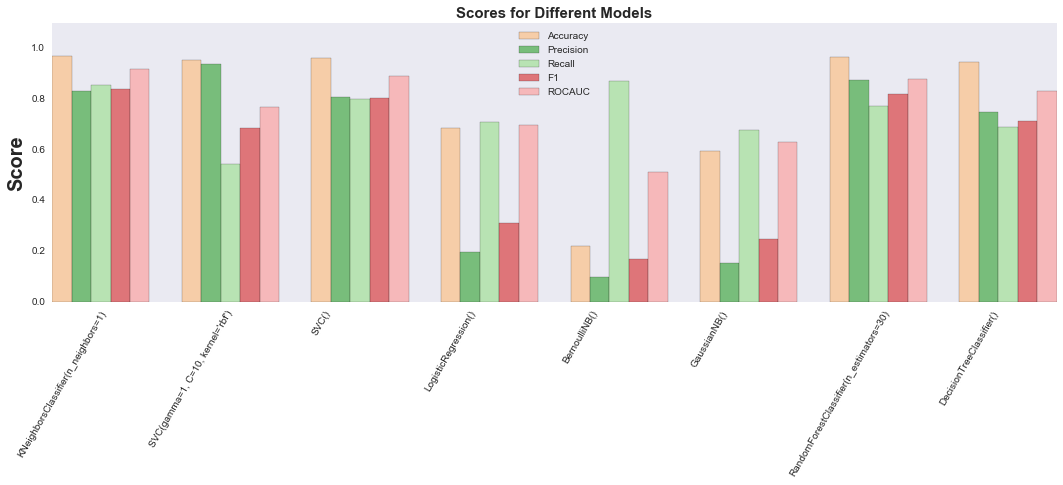

In [70]:
pol_modeling.get_multi_models(make_single_plot=True)

[[154   6]
 [  2  14]]
Avg Feature Importance: None
Accuracy: 0.9398863636363637
Precision: 0.6233305757552897
Recall: 0.87125
f1: 0.7255848325578748
ROC AUC: 0.909


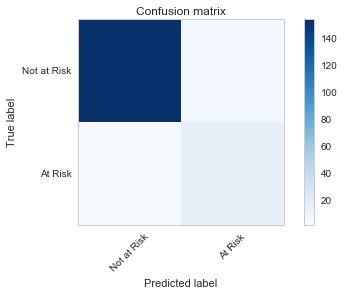

In [144]:
pol_modeling.get_single_model(model=KNeighborsClassifier(n_neighbors=1), 
                              year=2013, 
                              get_cm=True, 
                              output_prediction=True,
                              output_filename='prediction_2013.csv')

#### Without oversampling

In [71]:
pol_modeling.get_multi_models(oversample=False)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.961651,0.799209,0.827742,0.810160,0.902005
"SVC(gamma=1, C=10, kernel='rbf')",0.950032,0.942795,0.524516,0.670609,0.760498
SVC(),0.957206,0.929538,0.615484,0.735168,0.804995
LogisticRegression(),0.912381,0.896476,0.120645,0.208001,0.559724
BernoulliNB(),0.901587,0.000000,0.000000,0.000000,0.500000
GaussianNB(),0.790159,0.261628,0.603226,0.363675,0.706895
RandomForestClassifier(n_estimators=30),0.963111,0.914642,0.693548,0.783922,0.843042
DecisionTreeClassifier(),0.950286,0.747814,0.752903,0.747435,0.862367


#### KNN various n


n =  1
[[149  11]
 [  2  14]]
Avg Feature Importance: None
Accuracy: 0.9387499999999999
Precision: 0.6176424760848102
Recall: 0.8775
f1: 0.7234714714009874
ROC AUC: 0.9111874999999999


n =  2
[[152   8]
 [  2  14]]
Avg Feature Importance: None
Accuracy: 0.9367045454545455
Precision: 0.608126154953615
Recall: 0.8675
f1: 0.7136964503285951
ROC AUC: 0.9055625


n =  3
[[147  13]
 [  1  15]]
Avg Feature Importance: None
Accuracy: 0.9088636363636364
Precision: 0.5027912916150921
Recall: 0.9175
f1: 0.6482160040189819
ROC AUC: 0.91275




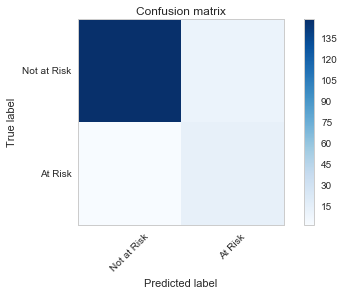

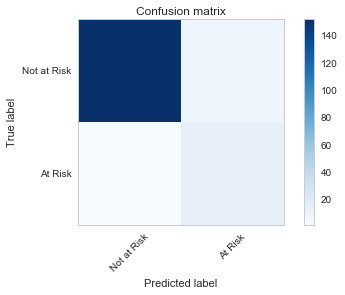

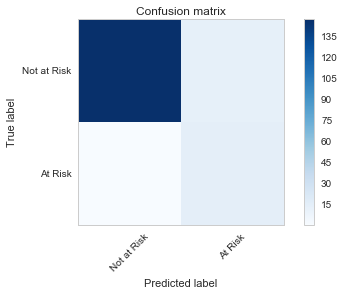

In [117]:
for n in range(1,4):
    print('n = ', n)
    pol_modeling.get_single_model(model=KNeighborsClassifier(n_neighbors=n), year=2013, get_cm=True)
    print('\n')

#### Random Forest for important features

[[282   2]
 [  4  27]]
Avg Feature Importance: [ 0.13885483  0.07160163  0.13168972  0.17586417  0.11658507  0.1539734
  0.21143118]
Accuracy: 0.9663492063492062
Precision: 0.8871463179262179
Recall: 0.756774193548387
f1: 0.8137881192939328
ROC AUC: 0.8729997728305317


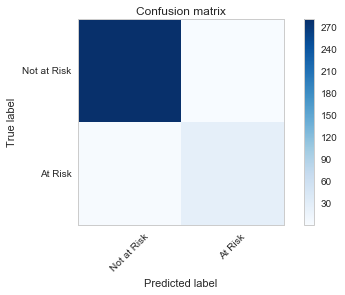

In [110]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.13361204  0.0729623   0.13351389  0.17793296  0.11833687  0.15242612
  0.21121581]
Accuracy: 0.9677460317460316
Precision: 0.879246889012347
Recall: 0.7812903225806452
f1: 0.8249810505830808
ROC AUC: 0.8846944570649705


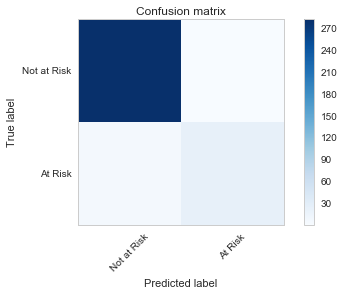

In [74]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.17853601  0.01546594  0.15180934  0.22430025  0.11378977  0.08804226
  0.22805642]
Accuracy: 0.9500952380952381
Precision: 0.7732391272921789
Recall: 0.7051612903225805
f1: 0.734356740748565
ROC AUC: 0.8409961381190368


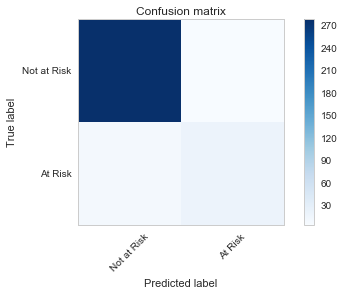

In [75]:
pol_modeling.get_single_model(model=DecisionTreeClassifier(), get_cm = True)

### Random forest, different number of trees

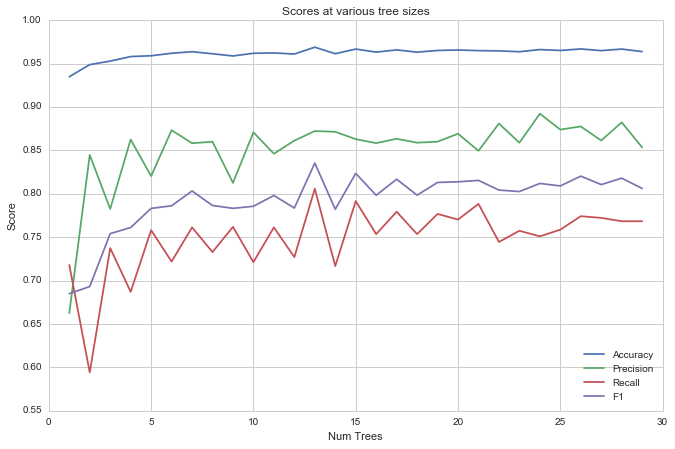

In [76]:
forest_acc = []
forest_prec = []
forest_rec = []
forest_f1 = []
forest_range = list(range(1,30))
for trees in forest_range:
    acc, prec, rec, f1, _ = pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=trees), verbose=False)
    forest_acc.append(acc)
    forest_prec.append(prec)
    forest_rec.append(rec)
    forest_f1.append(f1)

plt.figure(figsize=(11,7))
plt.plot(forest_range, forest_acc, label='Accuracy')
plt.plot(forest_range, forest_prec,label='Precision')
plt.plot(forest_range, forest_rec,label='Recall')
plt.plot(forest_range, forest_f1,label='F1')

plt.legend(loc='best')
plt.xlabel('Num Trees')
plt.ylabel('Score')
plt.title('Scores at various tree sizes')
plt.show()

    

## Testing for a single year

### With Oversampling

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.939318,0.620418,0.87750,0.725408,0.911500
"SVC(gamma=1, C=10, kernel='rbf')",0.947045,0.818446,0.54125,0.648577,0.764438
SVC(),0.942159,0.680321,0.68750,0.682381,0.827562
LogisticRegression(),0.681250,0.176530,0.68250,0.280048,0.681813
BernoulliNB(),0.640455,0.134908,0.39875,0.167123,0.531687
GaussianNB(),0.621591,0.151699,0.68625,0.248375,0.650687
RandomForestClassifier(n_estimators=30),0.937841,0.660737,0.65375,0.654936,0.810000
DecisionTreeClassifier(),0.924432,0.580059,0.62625,0.599689,0.790250


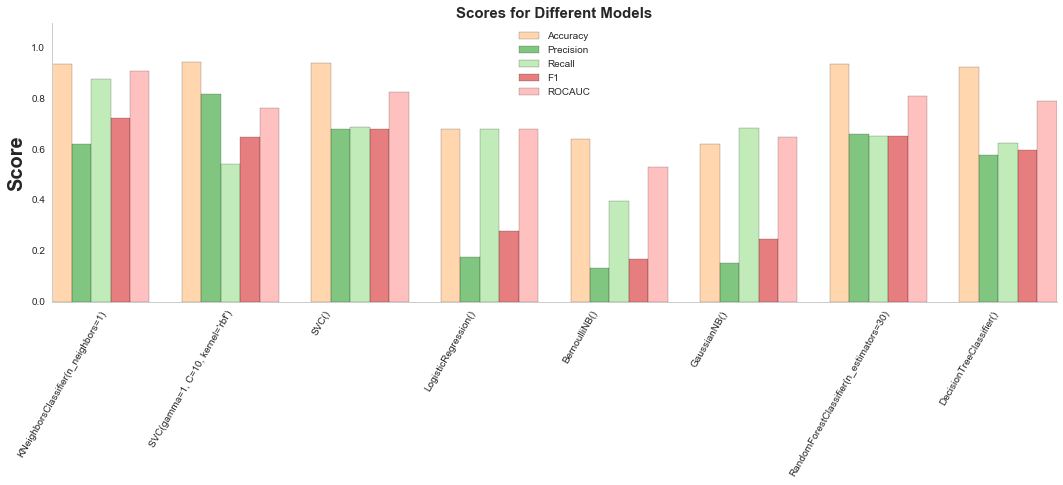

In [111]:
pol_modeling.get_multi_models(year=2013, make_single_plot=True)

In [78]:
pol_modeling.get_multi_models(year=2012)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.933295,0.735664,0.690476,0.711176,0.828335
"SVC(gamma=1, C=10, kernel='rbf')",0.929318,1.000000,0.407619,0.575894,0.703810
SVC(),0.934545,0.821968,0.578095,0.677470,0.780467
LogisticRegression(),0.667273,0.215651,0.677143,0.326586,0.671539
BernoulliNB(),0.528523,0.166983,0.530476,0.204099,0.529367
GaussianNB(),0.605000,0.183483,0.667619,0.287749,0.632068
RandomForestClassifier(n_estimators=30),0.940909,0.843927,0.623810,0.715652,0.803840
DecisionTreeClassifier(),0.917273,0.685261,0.580000,0.625065,0.771484


Avg Feature Importance: None
Accuracy: 0.9329545454545455
Precision: 0.7329946568739137
Recall: 0.6933333333333331
f1: 0.7111346774218376
ROC AUC: 0.8293763440860217


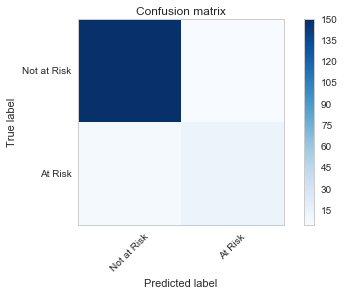

In [79]:
pol_modeling.get_single_model(year=2012, get_cm=True)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.948671,0.796863,0.720000,0.755053,0.848442
"SVC(gamma=1, C=10, kernel='rbf')",0.929595,0.988333,0.364211,0.528690,0.681781
SVC(),0.951098,0.912439,0.613684,0.732658,0.803206
LogisticRegression(),0.703931,0.224428,0.684211,0.337382,0.695287
BernoulliNB(),0.574566,0.120447,0.425263,0.145820,0.509125
GaussianNB(),0.600116,0.171470,0.686316,0.274229,0.637898
RandomForestClassifier(n_estimators=30),0.948208,0.835454,0.664211,0.737398,0.823729
DecisionTreeClassifier(),0.918728,0.646814,0.602105,0.620198,0.779949


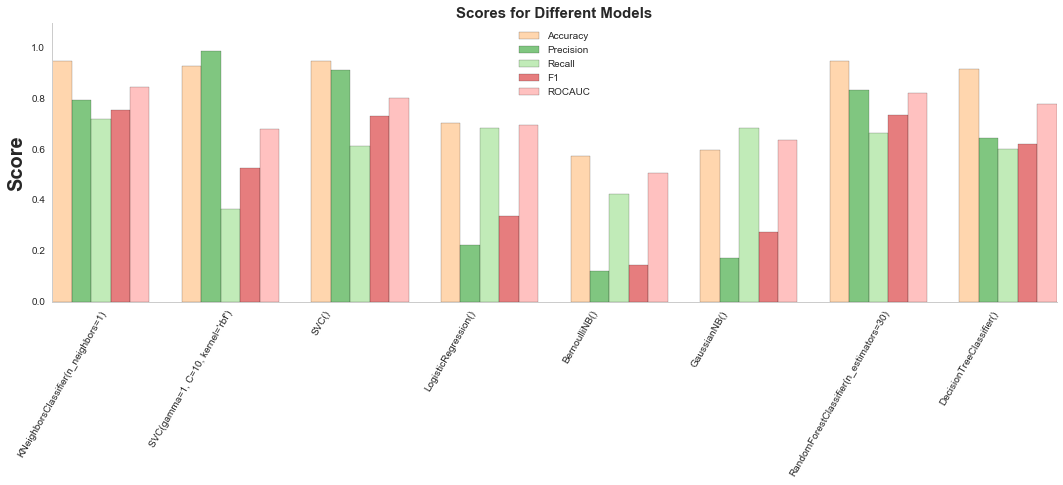

In [80]:
pol_modeling.get_multi_models(year=2011, year_delta=1, make_single_plot=True)

In [81]:
pol_modeling.get_multi_models(year=2011, year_delta=2)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=1),0.950233,0.673223,0.846667,0.748278,0.903397
"SVC(gamma=1, C=10, kernel='rbf')",0.945116,0.856405,0.444000,0.581428,0.718497
SVC(),0.950581,0.703277,0.756000,0.726982,0.862586
LogisticRegression(),0.709884,0.197099,0.752000,0.311929,0.728930
BernoulliNB(),0.563953,0.072904,0.416000,0.102594,0.497045
GaussianNB(),0.607326,0.148086,0.733333,0.246261,0.664310
RandomForestClassifier(n_estimators=30),0.950349,0.719014,0.712000,0.713486,0.842561
DecisionTreeClassifier(),0.924535,0.566934,0.656000,0.603727,0.803096


In [82]:
#full_data[full_data.zscores == 1]

In [83]:
pol_modeling.future_crisis_countries(model=RandomForestClassifier(n_estimators=30), year=2011, year_delta=1)

Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
Index: []
Empty DataFrame
Columns: [year_prior, prediction, prediction_actual, net]
In

In [84]:
#pol_modeling.SVC_grid_search(year=2011, year_delta=2)